# Scared to Debt

### How much will I repay in student loans?

It's a question that bugs nearly every student. After running some simulations on my personal situation, the results aren't as bad as I first imagined. 

If we assume that annual inflation will average 2.5% (hard to predict) and annual wage growth will average 2.1% (just as hard to predict) by 2048, then I will likely pay back around what I initially borrowed (~£50k) in 2018 money.

<br>

** *Note* **

- *This simulation devalues future payments made and outstanding debt based on estimated cumulative inflation to see what these figures might look like in 2018 money.*

- *It also accounts for steady rises in salary due to estimated future wage growth and (hopefully) pay rises throughout in my career.*

<br>

<details> <summary>See more</summary  

&nbsp;

*Wage estimates are calculated as 6 years of traveling (£0), 2 years of starting salary (£25-£30,000), and 22 years of thereafter steadily rising salary. Since I can't know when my salary will increase, each of the 22 years is evenly incremented by the difference between the starting salary and an estimated final salary. Multiple final salary estimates are calculated each factoring in estimated cumulative wage growth, giving us a more accurate picture of what an average, high or very high 2018 salary might look like by 2048.*
</details>

&nbsp;<br>

## Initial parameters

In [1]:
# initial debt (£000s)
bachelors_debt = 37
masters_debt = 13

# payback period - the loans will be written off after 30 years (in 2048 for me)
years = 30

# payback details
bachelor_payback_rate = 0.09 ### 9%
master_payback_rate = 0.06 ### 6%
payback_threshold = 27.295 ### £000s

# macroeconomics (estimated possible averages)
inflation_values = [0.023, 0.025, 0.027] ### different possible inflation values
wage_growth_values = [0.017, 0.021, 0.025] ### more spread possible wage growth values (refelcting a greater degree of uncertainty)

## Functions

In [2]:
# calculates eligible earnings as the difference between the repayment threshold and my actual earnings
def get_eligible_earnings(earnings):
    eligible_earnings = earnings - payback_threshold
    if eligible_earnings < 0:
        eligible_earnings = 0
    return eligible_earnings


# returns the interest rate - the government charges additional interest above the RPI the more you earn, but this is capped at 3%
def get_interest_rate(eligible_earnings, inflation):
    if eligible_earnings == 0:
        interest = inflation
    elif eligible_earnings >= 21834:
        interest = inflation + 0.03
    else:
        interest = inflation + ((0.03 / 21834) * eligible_earnings)
    return interest


# adds interest to the bachelors and masters debt
def add_debt_interest(sim_bachelors_debt, sim_masters_debt, interest):
    sim_bachelors_debt = (sim_bachelors_debt * (1 + interest))
    sim_masters_debt = (sim_masters_debt  * (1 + interest))
    return sim_bachelors_debt, sim_masters_debt


# calculates theoretical bachelors and masters repayments by multiplying eligible earnings by their respective payback rates
def calculate_payment(eligible_earnings):
    bachelors_payment = eligible_earnings * bachelor_payback_rate
    masters_payment = eligible_earnings * master_payback_rate
    return bachelors_payment, masters_payment


# adjusts any future figures to see what they look like in 2018 money
def inflation_adjusted(figure, years, inflation):
    for i in range(years):
        figure = figure * (1 - inflation)
    return figure


# reduces debt variables by the repayment amount and updates the amount paid
# paid is adjusted for inflation so we can see what it looks like in 2018 money
# the numbers are also adjusted accordingly if the remaining debt is less than the repayment amount
def update_figures(paid, sim_bachelors_debt, sim_masters_debt, bachelors_payment, masters_payment, i, inflation):
    
    # bachelors
    if sim_bachelors_debt >= bachelors_payment:
        paid += inflation_adjusted(bachelors_payment, i, inflation)
        sim_bachelors_debt -= bachelors_payment 
    else:
        paid += inflation_adjusted(sim_bachelors_debt, (i-1), inflation)
        sim_bachelors_debt -= sim_bachelors_debt
    
    # masters
    if sim_masters_debt >= masters_payment:
        paid += inflation_adjusted(masters_payment, i, inflation)
        sim_masters_debt -= masters_payment
    else:
        paid += inflation_adjusted(sim_masters_debt, (i-1), inflation)
        sim_masters_debt -= sim_masters_debt
        
    return paid, sim_bachelors_debt, sim_masters_debt


# the main simulation
def sim(earnings, inflation):

    # temporary variables to be altered each year
    sim_bachelors_debt = bachelors_debt
    sim_masters_debt = masters_debt
    paid = 0

    # loops over each year before the debt is wiped out, recording the amount paid and outstanding debt
    paid_ledger = []
    debt_ledger = []
    for i, year in enumerate(range(years)):

        # earnings that are eligible for loan repayments
        eligible_earnings = get_eligible_earnings(earnings[i])

        # interest rate to be charged (earnings dependent)
        interest = get_interest_rate(eligible_earnings, inflation)
        
        # adds interest
        sim_bachelors_debt, sim_masters_debt = add_debt_interest(sim_bachelors_debt, sim_masters_debt, interest)
        
        # calculates theoretical payements due
        bachelors_payment, masters_payment = calculate_payment(eligible_earnings)

        # updates the paid and debt variables based on repayment amounts
        paid, sim_bachelors_debt, sim_masters_debt = update_figures(paid, sim_bachelors_debt, sim_masters_debt, 
                                                                    bachelors_payment, masters_payment, i, inflation)
            
        # records the payment figure
        paid_ledger.append(paid)

        # records the total debt figure for each year (in 2018 money)
        total_debt = inflation_adjusted((sim_bachelors_debt + sim_masters_debt), i+1, inflation)
        debt_ledger.append(total_debt)

    return [total_debt, paid_ledger, debt_ledger]
    

# returns what a wage in 2018 (£40,000 for example) might look like when the debt is written off after 30 years (£74,600 for example)
def inflation_adjusted_wage(wage, wage_growth):
    for i in range(30):
        wage = wage * (1 + wage_growth)
    return wage


# returns a list of gradually incremented estimated yearly earnings given a starting salary and estimated final salary 
def get_earnings(starting_salary, end_salary, wage_growth):
    
    # 6 years of traveling / working abroad
    traveling = [0 for i in range(6)]
    
    # 2 years of starting salary
    starting_salary = [starting_salary for i in range(2)]
    
    # calculates 22 years of steadily rising income
    end = inflation_adjusted_wage(end_salary, wage_growth) ### what the end salary might look like in 30 years 
    avg_increment = (end-starting_salary[0]) / 22 ### # average increment each year after starting salary
    career_paychecks = []
    salary = starting_salary[0]
    for year in range(22):
        salary = salary + avg_increment
        career_paychecks.append(salary)

    # returns wage estimates for 30 years
    return traveling + starting_salary + career_paychecks


# plots the results of the simulation
import matplotlib.pyplot as plt
def plot(start_salary, end_salary, variable, subplot_title=''):

    # returns simulated results sets based on varied inflation if chosen as the variable factor
    if variable == 'Inflation':
        earnings = get_earnings(start_salary, end_salary, wage_growth=0.021) ### fixed earnings (wage growth = 2.1%)
        list = inflation_values ### a list object to be used in the legend of the subplot below
        colors = ['green', 'orange', 'red'] ### colors to be used in the subplot below
        # a results set containing results for each variation of inflation
        results_set = []
        for value in list:
            results_set.append(sim(earnings, value))

    # returns simulated results sets based on varied wage growth if chosen as the variable factor
    elif variable == 'Wage Growth':
        inflation = 0.025 ### fixed inflation (inflation = 2.5%)
        list = wage_growth_values ### a list object to be used in the legend of the subplot below
        colors = ['blue', 'purple', 'olive'] ### colors to be used in the subplot below
        # a results set containing results for each variation of wage growth
        results_set = []
        for value in list:
            earnings = get_earnings(start_salary, end_salary, wage_growth=value)
            results_set.append(sim(earnings, inflation))
    else:
        raise ValueError("Please choose either 'Inflation' or 'Wage Growth' for variable.")

    
    # outlines the parameters for the subplot below
    titles = ['Paid', 'Debt']
    ylabs = ['Paid (£000s)', 'Debt (£000s)']

    
    # loops through two subplots, one for total paid and the other for debt outstanding
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    for i in range(2):

        # creates a new plot line for each variation of the macroeconomic value chosen as the variable factor (inflation | wage growth)
        for j, results in enumerate(results_set): 
            ax[i].plot(range(years), results[i+1], color=colors[j])

        # sets the title dynamically based on the results
        first_value = round(results_set[0][i+1][len(results_set[0][i+1])-1],2)
        second_value = round(results_set[len(results_set)-1][i+1][len(results_set[1][i+1])-1],2)
        values = [first_value, second_value]
        mi = min(values)
        ma = max(values)
        if mi == ma:
            ax[i].set_title(titles[i] + ': £' + str(mi)  + 'k' , size=17)
        else:
            ax[i].set_title(titles[i] + ': £' + str(mi) + 'k' + ' - ' + '£' + str(ma)  + 'k' , size=17)
        
        ax[i].set_ylabel(ylabs[i], size=12)
        ax[i].set_xlabel('Years', size=12)
        ax[i].legend([round(x * 100, 2) for x in list], title=variable + ' (%)')

    fig.suptitle(subplot_title, size=25, y=1.075)

## Scenario 1: Average salary

If I earn £40,000 annually in 2018 money by the time I retire, I'll pay back below what I borrowed and around £10k is written off. 

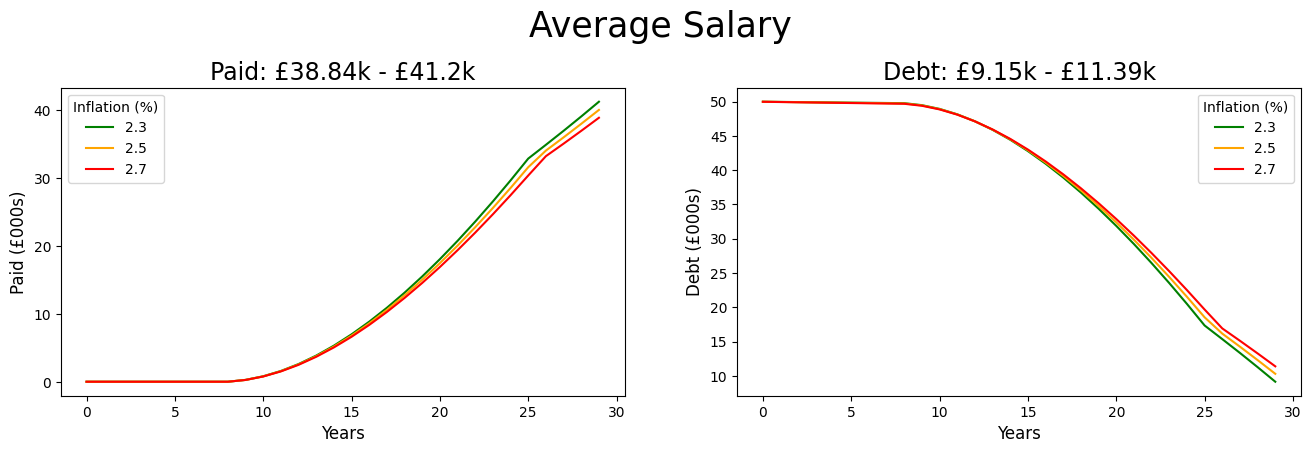

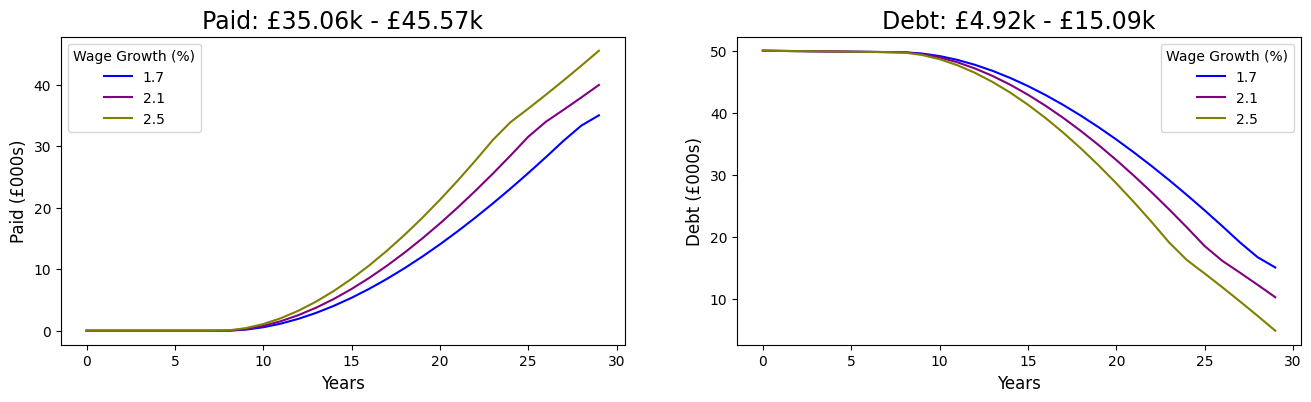

In [3]:
# plots the results for varied inflation and wage growth values
plot(25, 40, variable='Inflation', subplot_title='Average Salary')
plot(25, 40, variable='Wage Growth')

## Scenario 2: High salary

If I earn £60,000 annually in 2018 money by the time I retire, I'll pay back around what I borrowed and none is written off.

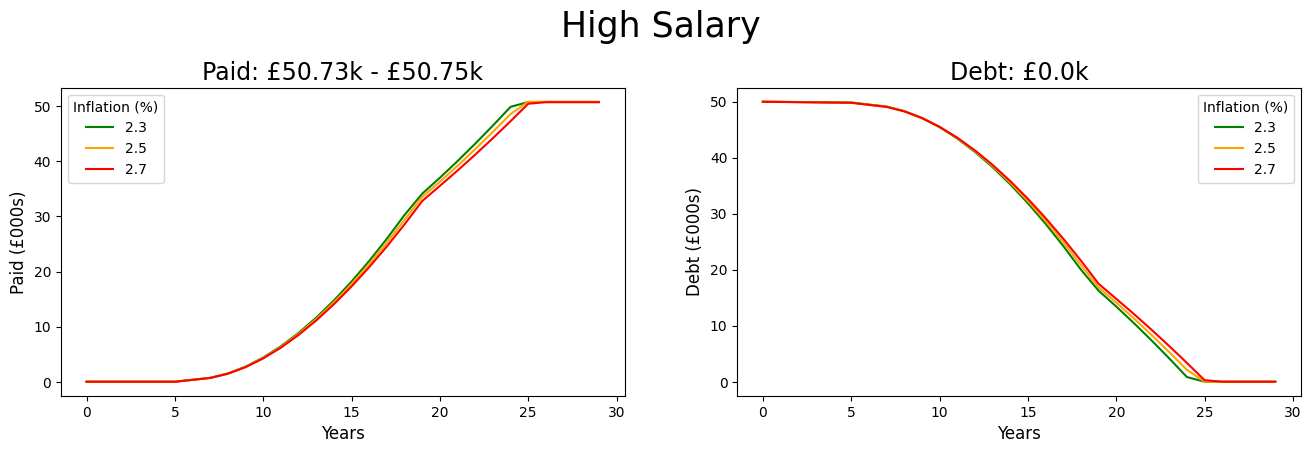

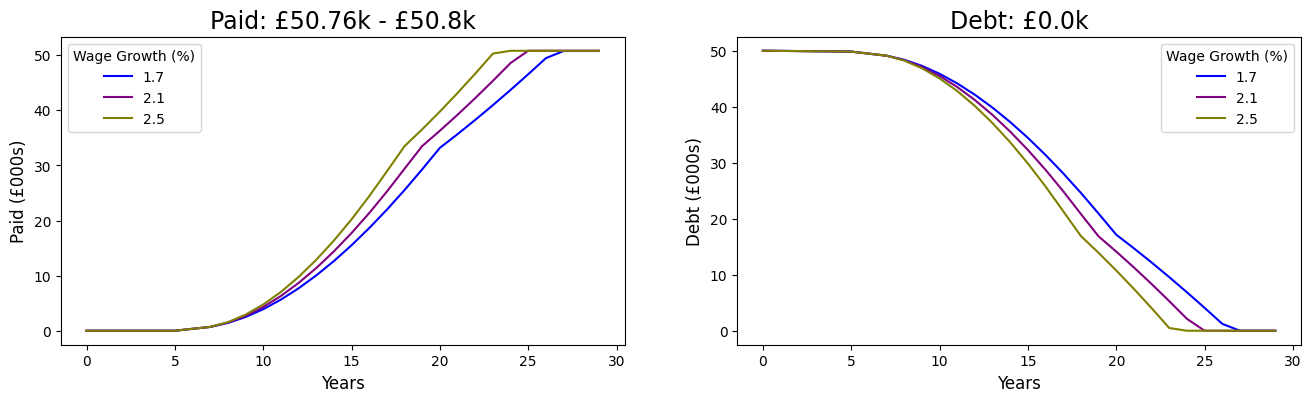

In [4]:
# plots the results for varied inflation and wage growth values
plot(30, 60, variable='Inflation', subplot_title='High Salary')
plot(30, 60, variable='Wage Growth')

## Scenario 3: Very high salary

If I earn £80,000 annually in 2018 money by the time I retire, I'll pay back around what I borrowed and none is written off.

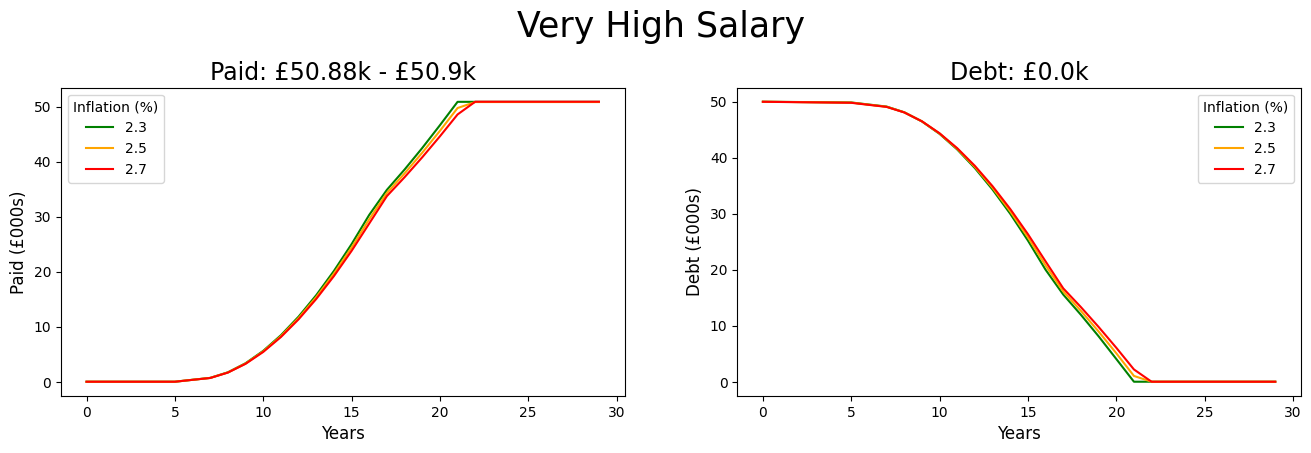

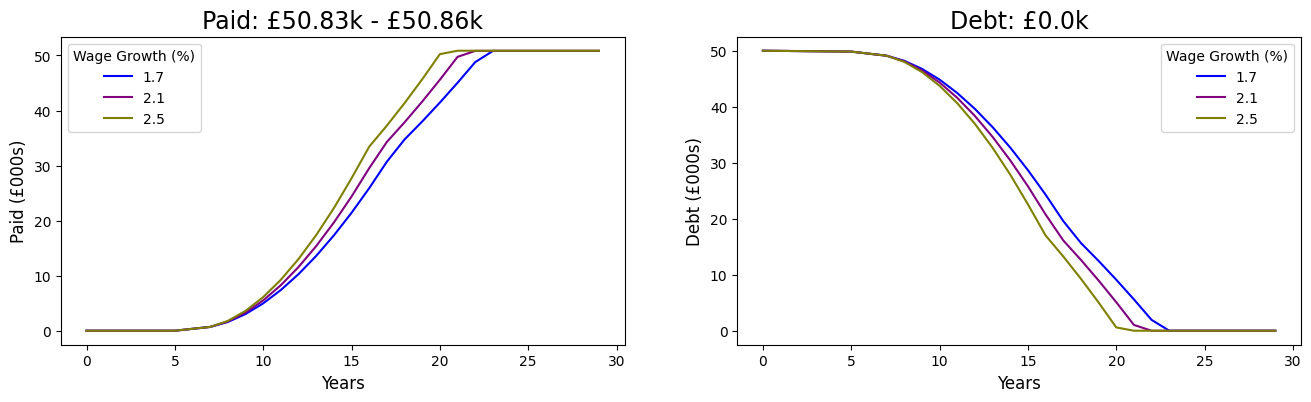

In [5]:
# plots the results for varied inflation and wage growth values
plot(30, 80, variable='Inflation', subplot_title='Very High Salary')
plot(30, 80, variable='Wage Growth')